In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import torch
from torchvision import datasets as d, transforms as t

from src.costs import *
from src.distributions import *
from src.loggers import WandbLogger
from src.models.simple import mlp
from src.models.resnet import resnet14_d
from src.plotters import Plotter, ImagePlotter
from src.train import run_experiment
from src.utils import *
from src.models.resnet2 import ResNet_D, ResNet_G, weights_init_D

In [12]:
logger = WandbLogger(
    project="optimal-transport",
    entity="_devourer_",
    group="test",
    # mode="offline",
)

plotter=ImagePlotter(n_images=20,
                     n_samples=2,
                     plot_source=False)

config = dict(
    num_epochs=1000,
    num_samples=128,
    num_steps_mover=10,
    num_steps_critic=1,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(2)
print(DEVICE)

cuda


### Case \#1: MNIST to 2D-GMM

In [4]:
features, classes = load_dataset(d.MNIST, root="../data/",
                                 transform=t.Compose([t.Resize(32), t.ToTensor()]))
source = TensorDatasetDistribution(features, classes, device=DEVICE)

n_components = 10
locs = 2 * uniform_circle(n_components)
scales = .2 * torch.ones_like(locs)
target = GaussianMixture(locs, scales, device=DEVICE)

p, q = source.event_shape.numel(), target.event_shape.numel()

U, s, V = torch.pca_lowrank(features.flatten(1), q)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [6]:
critic = mlp(q, hidden_size=128).to(DEVICE)
mover = resnet14_d(source.event_shape, q).to(DEVICE)

#### Fixed $P$ cost with random init

Output()

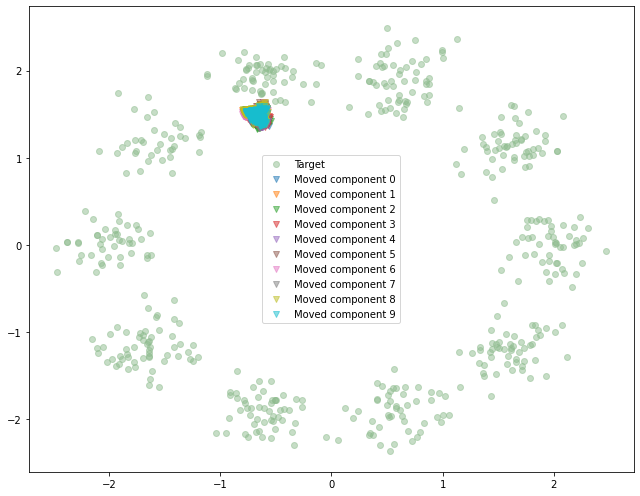

In [10]:
run_experiment(
    source, target, *copy_models(mover, critic),
    num_epochs=80,
    num_samples=256,
    cost=InnerGW(p, q, 
                 init=torch.randn(q, p, device=DEVICE) / (p * q),
                 device=DEVICE),
    plotter=Plotter(plot_interval=50,
                    plot_target=True,
                    plot_critic=False,
                    n_samples=512),
    # logger=logger
)

#### Fixed $P$ cost with PCA init

Output()

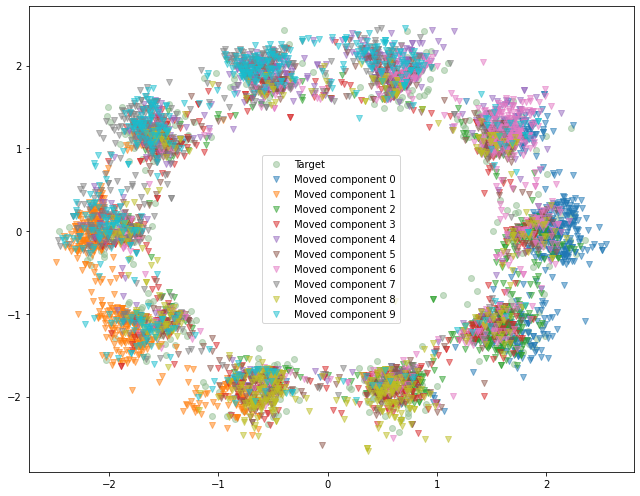

In [6]:
run_experiment(
    source, target, *copy_models(mover, critic),
    num_epochs=80,
    num_samples=256,
    cost=InnerGW(p, q,
                 init=V.T.to(DEVICE),
                 device=DEVICE),
    plotter=Plotter(plot_interval=50,
                    plot_target=True,
                    plot_critic=False,
                    n_samples=512),
    # logger=logger
)

#### Trainable $P$ cost

Output()

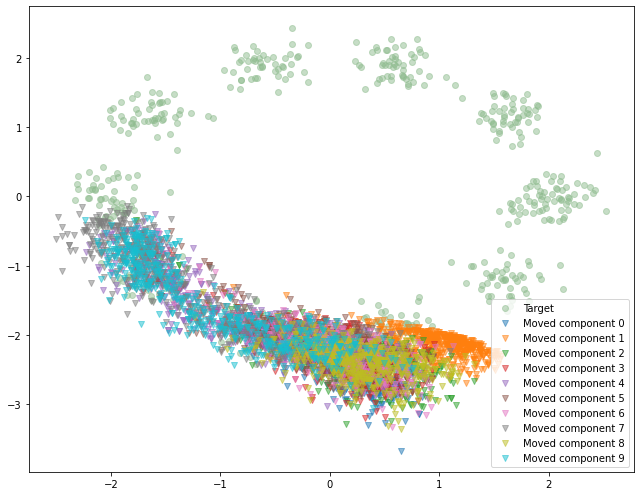

In [7]:
run_experiment(
    source, target, *copy_models(mover, critic),
    num_epochs=80,
    num_samples=256,
    cost=InnerGW_opt(p, q, device=DEVICE),
    plotter=Plotter(plot_interval=50,
                    plot_target=True,
                    plot_critic=False,
                    n_samples=512),
    # logger=logger
)

#### Trainable $P$ cost with PCA init

Output()

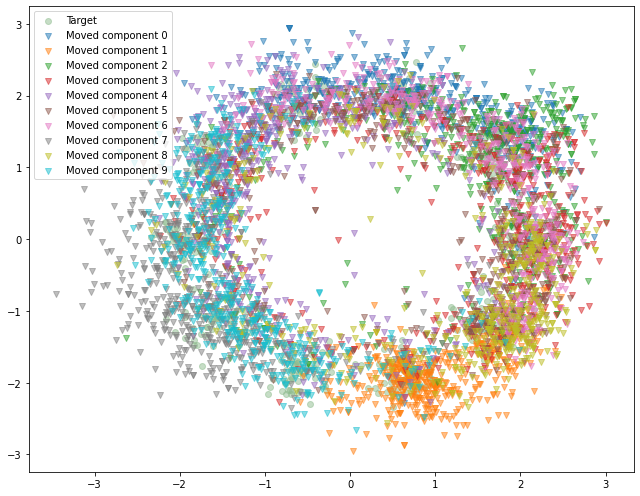

In [11]:
run_experiment(
    source, target, *copy_models(mover, critic),
    num_epochs=80,
    num_samples=256,
    num_steps_cost=10,
    cost=InnerGW_opt(p, q,
                     init=V.T.to(DEVICE),
                     device=DEVICE),
    plotter=Plotter(plot_interval=50,
                    plot_target=True,
                    plot_critic=False,
                    n_samples=512),
    # logger=logger
)

#### Kernel cost

Output()

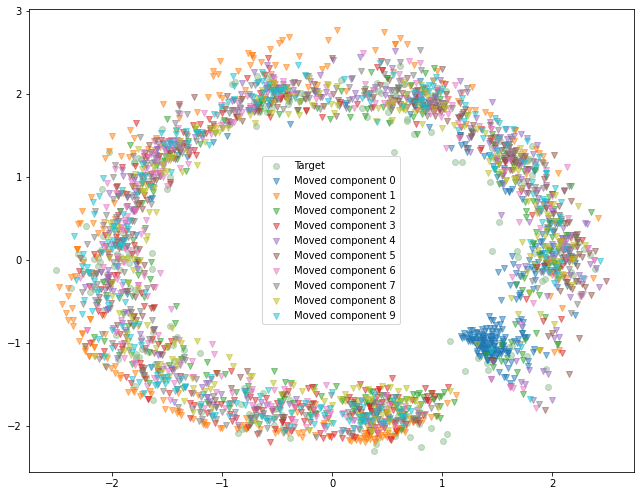

In [7]:
run_experiment(
    source, target, mover, critic,
    num_epochs=100,
    n_samples=256,
    num_steps_mover=5,
    cost=innerGW_kernel(kernel_1, source, mover, n_samples_mc=256),
    plotter=Plotter(plot_interval=50,
                    plot_target=True,
                    plot_critic=False,
                    plot_arrows=False,
                    n_samples=256),
    # logger=logger
)

### Case \#2: 3D-GMM to MNIST

In [5]:
n_components = 10
locs = fibonacci_sphere(n_components)
scales = torch.ones_like(locs)
source = GaussianMixture(locs, scales, device=DEVICE)

features, classes = load_dataset(d.MNIST, root="../data/",
                                 transform=t.Compose([t.Resize(32), t.ToTensor()]))
target = TensorDatasetDistribution(features, classes, device=DEVICE)
p, q = source.event_shape.numel(), target.event_shape.numel()

U, s, V = torch.pca_lowrank(features.flatten(1), p)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [13]:
critic = ResNet_D(size=32, nc=1).to(DEVICE).apply(weights_init_D)
mover = ResNet_G(p, 32, 1).to(DEVICE)

#### Fixed $P$ with PCA init

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Output()

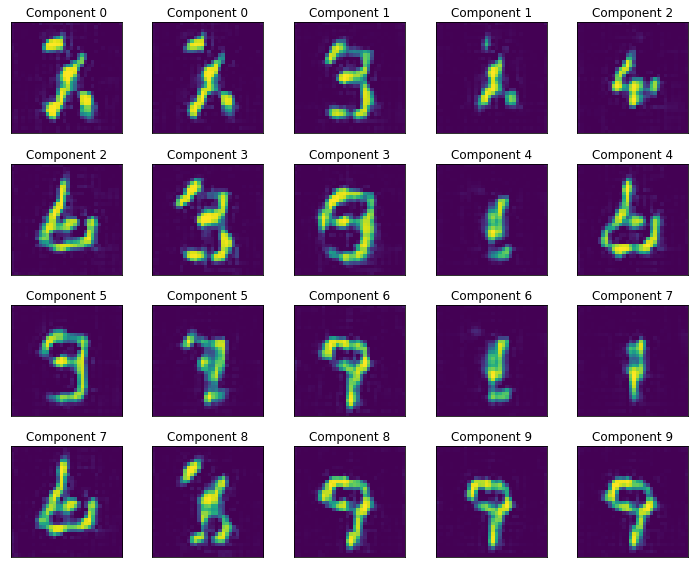

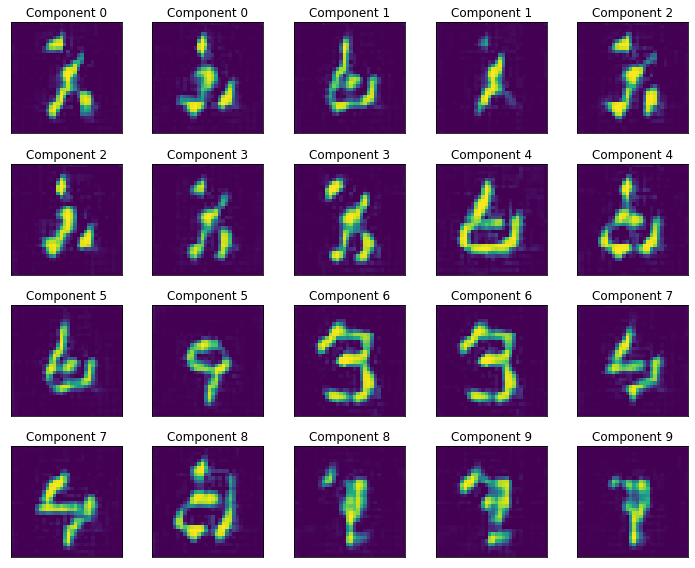

eval/GW,█████▇▇█▁▁▁▁▁▁▁▁▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁
eval/step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/cost,▃▃▆▂▄▃▄▃▅▂▅▂▅▁█▂▂▆▂▃▆▂▂▄▃▃▄▄▃▃▃▃▄▃▃▄▃▂▅▃
train/critic(h_x),▇▆▆▄▃▃▅▆▇▆▅▂▁▁▅▃▃▃▃▅▇▆▆▇▇███▇▇▇▆▆▆▇▇▆▆▇▆
train/critic(y),▆▆▆▅▄▃▅▆▇▆▅▃▁▂▄▃▄▃▃▅▆▆▇▇▇███▇▇▇▇▆▆▇▇▆▆▆▆
train/loss,▂▂▄▆▅▂▄▅█▂▆▅▅▅▁▁▅▄▁▄▃▃▄▄▄▄▅▄▅▄▅▄▄▄▅▆▄▄▄▃
train/step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/GW,1069.15808
eval/step,249
train/cost,0.00285
train/critic(h_x),0.0053


In [16]:
run_experiment(
    source, target, *copy_models(mover, critic),
    cost=InnerGW(p, q,
                 init=V.to(DEVICE),
                 device=DEVICE),
    plotter=plotter,
    logger=logger,
    **config
)

#### Trainable $P$ with PCA init

In [ ]:
run_experiment(
    source, target, *copy_models(mover, critic),
    num_steps_cost=10,
    cost=InnerGW_opt(p, q,
                     init=V.to(DEVICE),
                     device=DEVICE),
    plotter=plotter,
    logger=logger,
    **config
)

wandb: Currently logged in as: _devourer_ (use `wandb login --relogin` to force relogin)


Output()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

#### Kernel cost

In [ ]:
run_experiment(
    source, target, mover, critic,
    cost=innerGW_kernel(kernel_1, source, mover, n_samples_mc=64),
    plotter=plotter,
    logger=logger,
    **config
)


wandb: Currently logged in as: _devourer_ (use `wandb login --relogin` to force relogin)


Output()

### 64D-Normal to MNIST

In [40]:
loc = torch.zeros(64)
scale = torch.ones_like(locs)
source = to_composite(Normal(loc, scale, device=DEVICE))

features, classes = load_dataset(d.MNIST, root="../data/",
                                 transform=t.Compose([t.Resize(32), t.ToTensor()]))
target = TensorDatasetDistribution(features, classes, device=DEVICE)
p, q = source.event_shape.numel(), target.event_shape.numel()

U, s, V = torch.pca_lowrank(features.flatten(1), p)

In [55]:
critic = ResNet_D(size=32, nc=1).to(DEVICE).apply(weights_init_D)
mover = ResNet_G(p, 32, 1).to(DEVICE)

#### Fixed $P$ with PCA init

In [ ]:
run_experiment(
    source, target, *copy_models(mover, critic),
    cost=InnerGW(p, q,
                 init=V.to(DEVICE),
                 device=DEVICE),
    plotter=plotter,
    logger=logger,
    **config
)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Output()

#### Trainable $P$ with PCA init

In [56]:
run_experiment(
    source, target, *copy_models(mover, critic),
    num_steps_cost=10,
    cost=InnerGW_opt(p, q,
                     init=V.to(DEVICE),
                     device=DEVICE),
    plotter=plotter,
    logger=logger,
    **config
)

Output()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

#### Kernel cost

In [ ]:
run_experiment(
    source, target, mover, critic,
    cost=innerGW_kernel(kernel_1, source, mover, n_samples_mc=64),
    plotter=ImagePlotter(plot_interval=500,
                         n_images=20,
                         n_samples=2,
                         plot_source=False),
    plotter=plotter,
    logger=logger,
    **config
)


wandb: Currently logged in as: _devourer_ (use `wandb login --relogin` to force relogin)


Output()

### 64D-GMM to MNIST

In [4]:
n_components = 10
locs = torch.randn(n_components, 64)
scales = .5 * torch.ones_like(locs)
source = GaussianMixture(locs, scales, device=DEVICE)

features, classes = load_dataset(d.MNIST, root="../data/",
                                 transform=t.Compose([t.Resize(32), t.ToTensor()]))
target = TensorDatasetDistribution(features, classes, device=DEVICE)
p, q = source.event_shape.numel(), target.event_shape.numel()

U, s, V = torch.pca_lowrank(features.flatten(1), p)

In [5]:
critic = ResNet_D(size=32, nc=1).to(DEVICE).apply(weights_init_D)
mover = ResNet_G(p, 32, 1).to(DEVICE)

#### Fixed $P$ with PCA init

In [ ]:
run_experiment(
    source, target, *copy_models(mover, critic),
    cost=InnerGW(p, q,
                 init=V.to(DEVICE),
                 device=DEVICE),
    plotter=plotter,
    logger=logger,
    **config
)

wandb: Currently logged in as: _devourer_ (use `wandb login --relogin` to force relogin)


Output()

#### Trainable $P$ with PCA init

In [56]:
run_experiment(
    source, target, *copy_models(mover, critic),
    num_steps_cost=10,
    cost=InnerGW_opt(p, q,
                     init=V.to(DEVICE),
                     device=DEVICE),
    plotter=plotter,
    logger=logger,
    **config
)

Output()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

#### Kernel cost

In [ ]:
run_experiment(
    source, target, mover, critic,
    cost=innerGW_kernel(kernel_1, source, mover, n_samples_mc=64),
    plotter=plotter,
    logger=logger,
    **config
)


wandb: Currently logged in as: _devourer_ (use `wandb login --relogin` to force relogin)


Output()